In [1]:
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostRegressor
from algolab import API
from datetime import datetime
from config import *
import pandas as pd, numpy as np, json, os

import yfinance as yf

In [2]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
endeks=son.iloc[-1,:]
son=son.iloc[:-1,:]
hisseler=son["Kod"].values
hisseler=np.array(hisseler)
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [3]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,start="2010-01-01")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Date,,,,,,
2023-06-15,27.500000,27.500000,27.500000,27.500000,262214.0,A1CAP.IS
2023-06-16,30.240000,30.240000,30.240000,30.240000,1169499.0,A1CAP.IS
2023-06-20,31.100000,29.940001,31.000000,29.940001,8064437.0,A1CAP.IS
2023-06-21,26.959999,26.959999,26.959999,26.959999,2147415.0,A1CAP.IS
2023-06-22,27.620001,25.500000,25.620001,25.940001,71898180.0,A1CAP.IS
...,...,...,...,...,...,...
2024-06-05,8.070000,7.670000,7.970000,7.690000,2326506.0,ZRGYO.IS
2024-06-06,7.760000,7.530000,7.690000,7.540000,1654700.0,ZRGYO.IS
2024-06-07,8.080000,7.500000,7.600000,7.570000,13008816.0,ZRGYO.IS


In [4]:
df["Volume"]=df["Volume"]*df["Close"]

In [5]:
data=df.copy()

In [6]:
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)

In [7]:
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [8]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [9]:
df["Tavan"]=((((df["Adj Close"].shift(1))*1.1)/df["Kademe"]).fillna(0).astype(int))*df["Kademe"]
df["Tavan"]=np.round(df["Tavan"],2)

In [10]:
df["Tavan Kontrol"]=np.where((df["Tavan"]==df["Adj Close"]),1,0)

In [11]:
import pandas_ta as ta

df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()

# RSI
df["RSI"] = ta.rsi(df["Adj Close"],14)

# Bağıl Hacim
df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)




In [12]:
import pandas_ta as ta
import ta as ta1

df['MACD_Signal'] = df["Signal_Line"]
df['MACD_Diff'] = ta1.trend.macd_diff(df['Adj Close'])
df['ROC'] = ta.roc(df["Adj Close"],12)



In [13]:
df["Return"]=100*((df["Open"]/df["Adj Close"].shift(2))-1)
df["Return"]=df["Return"].shift(-2)
df["Date"]=pd.to_datetime(df.index)
df


,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol,SMA 5,...,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,MACD_Signal,MACD_Diff,ROC,Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,0.00,0,NaN,...,NaN,0,0,0,0,NaN,NaN,NaN,12.727273,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,30.24,1,NaN,...,NaN,0,0,0,0,NaN,NaN,NaN,-10.846561,2023-06-16
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,33.26,0,NaN,...,NaN,0,0,0,0,NaN,NaN,NaN,-14.428858,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,32.92,0,NaN,...,NaN,0,0,0,0,NaN,NaN,NaN,-3.041543,2023-06-21
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,29.64,0,28.116,...,NaN,0,0,0,0,NaN,NaN,NaN,-0.154202,2023-06-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0.01,8.74,0,7.930,...,0.12,0,0,0,0,0.195075,0.035199,0.918635,-1.170351,2024-06-05
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0.01,8.45,0,7.860,...,0.32,0,0,0,0,0.197202,0.008509,-1.694915,1.458886,2024-06-06
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0.01,8.29,0,7.742,...,0.47,0,0,1,0,0.195065,-0.008549,0.000000,-3.963012,2024-06-07


In [14]:
endeks1=yf.download(tickers="XU100.IS",end="2020-07-27")/100
endeks2=yf.download(tickers="XU100.IS",start="2020-07-27")
endeks=pd.concat([endeks1,endeks2],axis=0)
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Endeks Return Lag"]=100*((df["Endeks"].shift(1)/df["Endeks"].shift(2))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol,SMA 5,...,MACD+Stoch,MACD_Signal,MACD_Diff,ROC,Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,0.00,0,NaN,...,0,NaN,NaN,NaN,12.727273,2023-06-15,5495.500000,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,30.24,1,NaN,...,0,NaN,NaN,NaN,-10.846561,2023-06-16,5475.500000,-0.363934,NaN,9.963636
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,33.26,0,NaN,...,0,NaN,NaN,NaN,-14.428858,2023-06-20,5251.600098,-4.089122,-0.363934,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,32.92,0,NaN,...,0,NaN,NaN,NaN,-3.041543,2023-06-21,5186.799805,-1.233915,-4.089122,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,29.64,0,28.116,...,0,NaN,NaN,NaN,-0.154202,2023-06-22,5428.299805,4.656050,-1.233915,-3.783383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,8.07,7.67,7.97,7.69,1.789083e+07,ZRGYO.IS,0.01,8.74,0,7.930,...,0,0.195075,0.035199,0.918635,-1.170351,2024-06-05,10351.000000,-0.131212,-1.820629,-3.270440
2024-06-06,7.76,7.53,7.69,7.54,1.247644e+07,ZRGYO.IS,0.01,8.45,0,7.860,...,0,0.197202,0.008509,-1.694915,1.458886,2024-06-06,10279.700195,-0.688820,-0.131212,-1.950585
2024-06-07,8.08,7.50,7.60,7.57,9.847674e+07,ZRGYO.IS,0.01,8.29,0,7.742,...,0,0.195065,-0.008549,0.000000,-3.963012,2024-06-07,10139.000000,-1.368719,-0.688820,0.397878


In [15]:
df=df.sort_index()

In [16]:
target_data = {
    "2024-02-13": "PATEK.IS",
    "2024-02-15": "BORSK.IS",
    "2024-02-22": "LMKDC.IS",
    "2024-02-29": "ALVES.IS",
    "2024-03-04": "ARTMS.IS",
    "2024-03-05": "MOGAN.IS",
    "2024-03-11": ["BARMA.IS", "INVES.IS", "EDATA.IS"],
    "2024-03-21": "ODINE.IS",
    "2024-04-26": "RGYAS.IS",
    "2024-05-02": ["OBAMS.IS", "ENTRA.IS"],
    "2024-05-09": "LILAK.IS",
    "2024-05-10": "KOTON.IS",
    "2024-05-16": "ALTNY.IS",
    "2024-05-17": "KOCMT.IS",
    "2024-05-23": "HRKET.IS",
    "2024-05-27": "PEHOL.IS",
    "2024-05-28": "ONRYT.IS",
    "2024-05-29": "OZYSR.IS",
    "2024-06-04": "ALKLC.IS",
    "2024-06-06": "YIGIT.IS",
    "2024-06-07": "HOROZ.IS"
}
for date, stocks in target_data.items():
    if isinstance(stocks, list):
        for stock in stocks:
            df.loc[(df.index == date) & (df["Hisse"] == stock), "Tavan Kontrol"] = 1
    else:
        df.loc[(df.index == date) & (df["Hisse"] == stocks), "Tavan Kontrol"] = 1
son=df.loc["2024-06-10":]
ilk=df.loc[:"2024-06-07"]
ilk=ilk[(ilk["Return"]<21) & (ilk["Return"]>-19)]
result=pd.concat([ilk,son],axis=0)

In [17]:
df=df.sort_index()

yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"
result=result.dropna()
result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result[result["Tavan Kontrol"]==0]
result=result.sort_index()


In [18]:
params = {'iterations': 406,
 'depth': 8,
 'learning_rate': 0.05908481614373525,
 'random_strength': 15,
 'bagging_temperature': 0.48897432777080385,
 'border_count': 163,
 'l2_leaf_reg': 9}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=42)
model.load_model("./model/xtumyson.bin")

In [19]:
test=result.loc["2024-01-02":]
X_test=test[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
tahminler=pd.DataFrame(test["Return"])
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=model.predict(X_test)
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)

In [20]:
endeks1=yf.download(tickers="XU100.IS",start="2024-01-01",end="2024-06-10")
endeks1["Getiri"]=0
for i in range(len(endeks1)):
    endeks1["Getiri"].iloc[i]=100*((endeks1["Adj Close"].iloc[i]/endeks1["Adj Close"].iloc[0])-1)
endeks1=endeks1.fillna(0)


[*********************100%%**********************]  1 of 1 completed
C:\Users\Bora\AppData\Local\Temp\ipykernel_4796\2033698123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endeks1["Getiri"].iloc[i]=100*((endeks1["Adj Close"].iloc[i]/endeks1["Adj Close"].iloc[0])-1)
C:\Users\Bora\AppData\Local\Temp\ipykernel_4796\2033698123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endeks1["Getiri"].iloc[i]=100*((endeks1["Adj Close"].iloc[i]/endeks1["Adj Close"].iloc[0])-1)
C:\Users\Bora\AppData\Local\Temp\ipykernel_4796\2033698123.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [21]:
returns=top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].dropna()/2
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Gerçek,Kar
Date,,
2024-01-02,-0.003969,0
2024-01-03,0.038414,1
2024-01-04,0.034680,1
2024-01-05,0.031485,1
2024-01-08,0.017976,1
...,...,...
2024-06-03,-0.009744,0
2024-06-04,-0.013808,0
2024-06-05,0.031270,1


In [22]:
endeks1["Return"]=(endeks1["Adj Close"]/endeks1["Adj Close"].shift(1))-1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


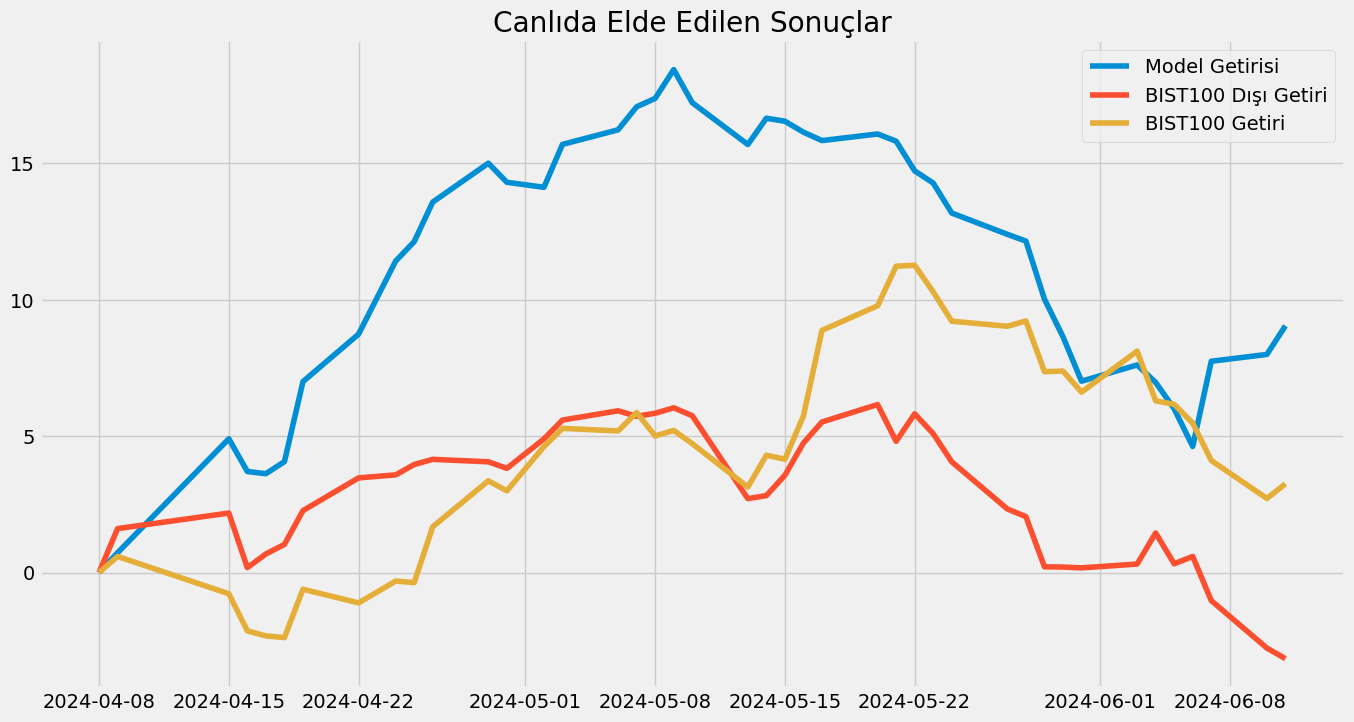

In [23]:
trade=pd.read_excel("./excel/trade.xlsx")
sonuclar=trade[["Kar(%).1","Endeks(%)"]].dropna()
sonuclar=sonuclar.set_index(yf.download(tickers="XU100.IS",start="2024-04-08").index)
endeks=yf.download(tickers="XU100.IS",start="2024-04-08")
endeks["Getiri"]=100*((endeks["Adj Close"]/endeks["Adj Close"].shift(1))-1)
endeks["Getiri"]=endeks["Getiri"].fillna(0)


import matplotlib.pyplot as plt


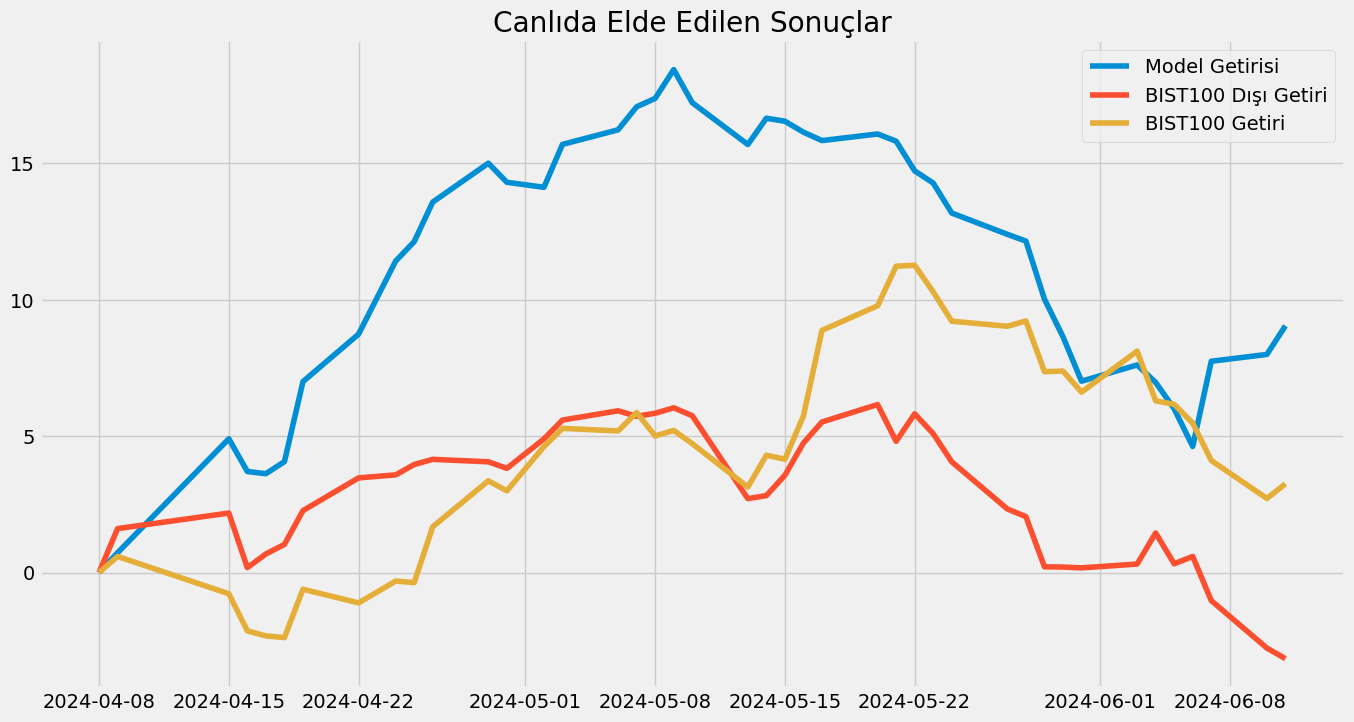

In [28]:
import matplotlib.pyplot as plt
import io
from telegram import Update
from telegram.ext import Updater, CommandHandler, CallbackContext
import telegram

# Bot token'ınızı buraya yapıştırın
BOT_TOKEN = '6994011653:AAH8kaRmhMqfHyp634PiaTP1ri63onS56Nk'
# Kanal kullanıcı adı ya da ID'si
CHANNEL_ID = '6356198553'  # ya da '-1001234567890' formatında kanal ID'si

# Bot nesnesini oluşturun
bot = telegram.Bot(token=BOT_TOKEN)

# /start komutu için callback fonksiyonu
def start(update: Update, context: CallbackContext) -> None:
    update.message.reply_text('Bu botu kullanarak şunları yapabilirsiniz: \n/start - Başlangıç mesajı\n/canlisonuclar\n/backtest\n/stats')

# /help komutu için callback fonksiyonu
def help_command(update: Update, context: CallbackContext) -> None:
    update.message.reply_text('Bu botu kullanarak şunları yapabilirsiniz: \n/start - Başlangıç mesajı\n/canlisonuclar\n/backtest\n/stats')

# Gelen mesajları yakalama ve yanıt verme fonksiyonu
def echo(update: Update, context: CallbackContext) -> None:
    update.message.reply_text(update.message.text)

def canlisonuclar(update: Update, context: CallbackContext) -> None:
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(15,8))
    plt.title("Canlıda Elde Edilen Sonuçlar")
    plt.plot(sonuclar["Kar(%).1"].cumsum(),label="Model Getirisi")
    plt.plot(sonuclar["Endeks(%)"].cumsum(),label="BIST100 Dışı Getiri")
    plt.plot(endeks["Getiri"].cumsum(),label="BIST100 Getiri")
    plt.legend()

    # Grafiği byte dizisine kaydetme
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Grafiği Telegram'a gönderme
    update.message.reply_photo(photo=buf)

HTML_FILE_PATH = 'stochk_macd_roc_macdsignal_mom_endeks.html'

def backtest(update: Update, context: CallbackContext) -> None:
    # HTML dosyasını açma ve Telegram'a gönderme
    with open(HTML_FILE_PATH, 'rb') as file:
        update.message.reply_document(document=file, filename='report.html')
TXT_FILE_PATH = 'stats.txt'

def stats(update: Update, context: CallbackContext) -> None:
    # TXT dosyasını açma ve içeriğini okuma
    try:
        with open(TXT_FILE_PATH, 'r', encoding='utf-8') as file:
            content = file.read()
            update.message.reply_text(content)
    except Exception as e:
        update.message.reply_text(f"Dosya okunurken bir hata oluştu: {e}")




def main() -> None:
    # Updater nesnesini oluşturun ve bot token'ını ekleyin
    updater = Updater(BOT_TOKEN)

    # Dispatcher nesnesi ile komutları ekleyin
    dispatcher = updater.dispatcher

    # /start ve /help komutları için handler'ları ekleyin
    dispatcher.add_handler(CommandHandler("start", start))
    dispatcher.add_handler(CommandHandler("help", help_command))
    dispatcher.add_handler(CommandHandler("canlisonuclar", canlisonuclar))
    dispatcher.add_handler(CommandHandler("backtest", backtest))
    dispatcher.add_handler(CommandHandler("stats", stats))

    # Botu başlatın
    updater.start_polling()

    # Botu çalışır durumda tutun
    updater.idle()

if __name__ == '__main__':
    main()
